In [1]:
import os,sys
ROOT_DIR = os.path.abspath("../../")
DATA_DIR = os.path.join(ROOT_DIR, 'data/processed')
sys.path.append(ROOT_DIR)
# to write to evaluate path 


from src.data import helper
from src.data.cityscapeDataset import CityscapeDataset
from src.data.cityscapeConfig import CityscapeConfig


import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt

# modeli import
from models.maskrcnn.mrcnn import visualize
# from models.maskrcnn.mrcnn import model as modellib
from models.maskrcnn.mrcnn import model_new as modellib
from models.maskrcnn.mrcnn.model import log
from models.maskrcnn.mrcnn import config
from models.maskrcnn.mrcnn.config import Config
from models.maskrcnn.mrcnn import utils

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [2]:
# model_path = os.path.join(ROOT_DIR,'models/maskrcnn/mask_rcnn_sidewalks_0001.h5')
# dataset = val_set
dataset = CityscapeDataset()
dataset.load_dataset(DATA_DIR,'test')
dataset.prepare()

class InferenceConfig(CityscapeConfig):
  GPU_COUNT =1 
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = .5
  IMAGE_MAX_DIM = 512
  IMAGE_MIN_DIM = 512
  USE_MINI_MASK = True

inference_config = InferenceConfig()

In [614]:
temp_log = os.path.join(ROOT_DIR,'data/external')
model_path = '/Users/csea/Desktop/deep-learning-final-project-project-sidewalk/data/logs/one_dense/mask_rcnn_sidewalks_0019.h5'
# model_path ='/Users/csea/Desktop/logs_nicholas/mask_rcnn_sidewalks_0020_fixed_dense.h5'
# model_path='/Users/csea/Desktop/deep-learning-final-project-project-sidewalk/models/maskrcnn/logs/logs_FocalBCE/mask_rcnn_sidewalks_0020.h5'
tf.keras.backend.clear_session()
model = modellib.MaskRCNN(mode = 'inference',
                          config = inference_config,
                          model_dir=temp_log)

# loading weights to model
tf.keras.Model.load_weights(model.keras_model, model_path, by_name=True)

2023-05-23 16:42:42.866541: W tensorflow/c/c_api.cc:300] Operation '{name:'mrcnn_mask/bias/Assign' id:7349 op device:{requested: '', assigned: ''} def:{{{node mrcnn_mask/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](mrcnn_mask/bias, mrcnn_mask/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


# Using Object Detection Tool

In [ ]:
EVAL_DIR = os.path.join(ROOT_DIR,'data','eval','new_ep10')
ALL_CLASSES = os.path.join(EVAL_DIR,'all_classes')
OBS_CLASSES = os.path.join(EVAL_DIR, 'obstructions')
if not os.path.exists(ALL_CLASSES):
    os.makedirs(ALL_CLASSES)
    os.makedirs(os.path.join(ALL_CLASSES,'groundtruths'))
    os.makedirs(os.path.join(ALL_CLASSES,'detections'))

if not os.path.exists(OBS_CLASSES):
    os.makedirs(OBS_CLASSES)
    os.makedirs(os.path.join(OBS_CLASSES,'groundtruths'))
    os.makedirs(os.path.join(OBS_CLASSES,'detections'))

In [ ]:
def detect(model, dataset, gt_dir=ALL_CLASSES, obs_dir = OBS_CLASSES):
    # for each image in the dataset
    class_names = dataset.class_names
    for id in dataset.image_ids:
        if id%50==0: print(f'Done detecting {id} images')
        img_name = dataset.image_info[id]['id']
        image = dataset.load_image(id)

        # get its ground truth values 
        gt_mask, gt_class_ids, gt_obs = dataset.load_mask(id)
        gt_bbox = utils.extract_bboxes(gt_mask)

        
        # write gt into txt file
        # <class>  <x1,y1,x2,y2>
        gt_ids = []
        gt_obs_ids = []
        for i in range(len(gt_class_ids)):
            class_id = gt_class_ids[i]
            y1,x1,y2,x2 = gt_bbox[i]
            line = class_names[class_id] + ' '+ str(x1) + ' '+ str(y1) + ' '+ str(x2) + ' '+ str(y2)
            gt_ids.append(line)

            # find the obstructions labels
            if gt_obs[i] ==1: gt_obs_ids.append(line)
        
        # get its detection
        # <class>   <score>     <x1,y1,x2,y2>

        detections = model.detect([image],verbose=0)
        bboxes, masks, class_ids, class_scores, obs_ids, obs_scores = helper.parse_detections(detections)
        # write dets into txt file
        dets_ids = []
        dets_obs = []
        for i in range(len(class_ids)):
            class_id = class_ids[i]
            y1,x1,y2,x2 = bboxes[i]
            line = class_names[class_id] + ' '+ str(class_scores[i])+' '+str(x1) + ' '+ str(y1) + ' '+ str(x2) + ' '+ str(y2)
            dets_ids.append(line)

            # find the obstructions labels
            if obs_ids[i] ==1: 
                line = class_names[class_id] + ' '+ str(obs_scores[i])+' '+str(x1) + ' '+ str(y1) + ' '+ str(x2) + ' '+ str(y2)
                dets_obs.append(line)
                
        # now write the files 
        # with open('readme.txt', 'w') as f:
            # f.write('\n'.join(lines))       
        with open(os.path.join(gt_dir, 'groundtruths',f'{img_name}.txt'),'w') as f:
            f.write('\n'.join(gt_ids))
        with open(os.path.join(gt_dir, 'detections',f'{img_name}.txt'),'w') as f:
            f.write('\n'.join(dets_ids))
        with open(os.path.join(obs_dir, 'groundtruths',f'{img_name}.txt'),'w') as f:
            f.write('\n'.join(gt_obs_ids))
        with open(os.path.join(obs_dir, 'detections',f'{img_name}.txt'),'w') as f:
            f.write('\n'.join(dets_obs))
        

# Visual check


Processing 1 images
image                    shape: (1024, 2048, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


/Users/csea/miniconda/envs/tf/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-05-23 16:42:48.984019: W tensorflow/c/c_api.cc:300] Operation '{name:'mrcnn_detection/Reshape_1' id:6869 op device:{requested: '', assigned: ''} def:{{{node mrcnn_detection/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](mrcnn_detection/packed, mrcnn_detection/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-23 16:42:49.376970: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type

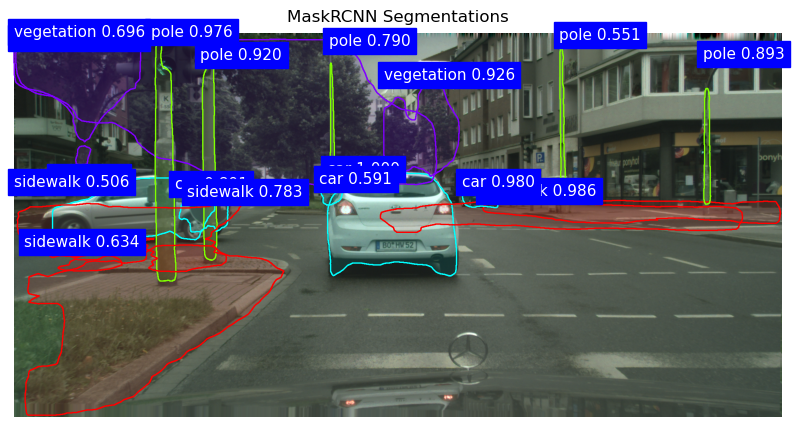

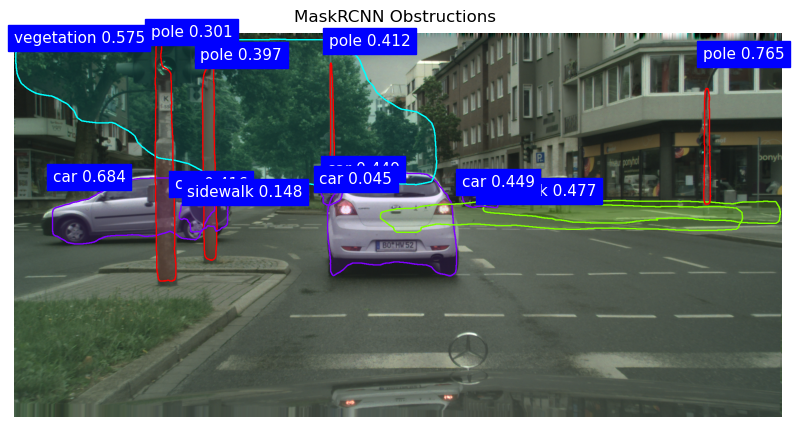

In [615]:
ids = random.choice(dataset.image_ids)
# ids = 272
# print(ids, dataset.image_info[ids]['id'])
# ids = 1
image = dataset.load_image(ids)
results = model.detect([image],verbose=1)
# display preferences
def get_ax(rows=1, cols=1, size=10):
  _,ax = plt.subplots(rows,cols,figsize=(size*cols,size*rows))
  return ax

# captions = helper.generate_captions_obstructed(r['class_ids'], r['obstructions'],labels_dict = val_set.rev_mapping)
bboxes, masks, class_ids, class_scores, obs_ids, obs_scores = helper.parse_detections(results)

visualize.display_instances(image, bboxes, masks, class_ids, 
                           list(dataset.class_from_source_map.values()), class_scores, 
                           ax=get_ax(), title='MaskRCNN Segmentations', show_bbox=False)


idx = np.where(obs_ids==1)[0]
# idx = np.where(r['obstructions_scores']>.5)[0]


b,m,l = helper.filter_obstructions(idx, bboxes, masks, class_ids)
visualize.display_instances(image, b,m,l, 
                           list(dataset.class_from_source_map.values()), obs_scores[idx], 
                           ax=get_ax(),title='MaskRCNN Obstructions ', show_bbox=False)
                           

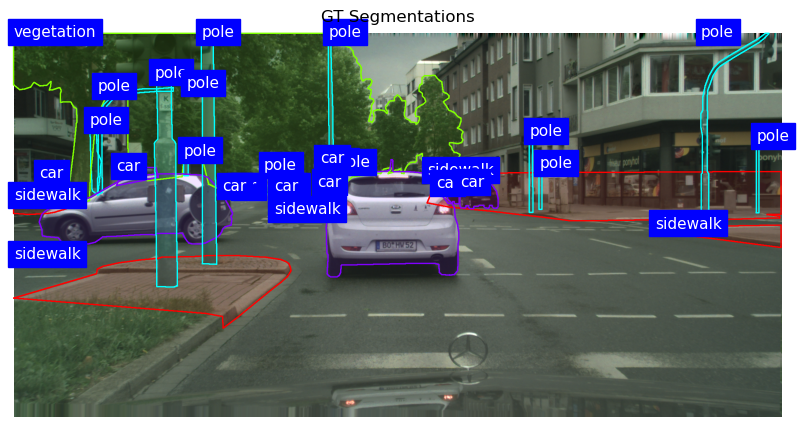

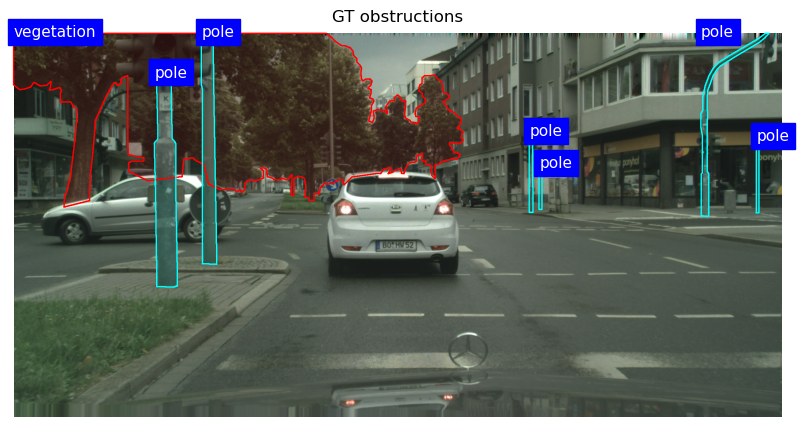

In [616]:
# image = dataset.load_image(ids)
# ids = 122
gt_mask, gt_class_ids, gt_obs = dataset.load_mask(ids)
gt_bbox = utils.extract_bboxes(gt_mask)

def get_ax(rows=1, cols=1, size=10):
  _,ax = plt.subplots(rows,cols,figsize=(size*cols,size*rows))
  return ax

_ = np.where(gt_obs==1)[0]
visualize.display_instances(image, gt_bbox,gt_mask, gt_class_ids, 
                            list(dataset.class_from_source_map.values()), ax=get_ax(), 
                            show_bbox=False, title='GT Segmentations')

gt_bbox_filtered,gt_mask_filtered,gt_class_ids_filtered = helper.filter_obstructions(_, gt_bbox,gt_mask,gt_class_ids)
visualize.display_instances(image, gt_bbox_filtered,gt_mask_filtered, gt_class_ids_filtered,
                            list(dataset.class_from_source_map.values()), 
                            ax=get_ax(), show_bbox=False, title = 'GT obstructions')

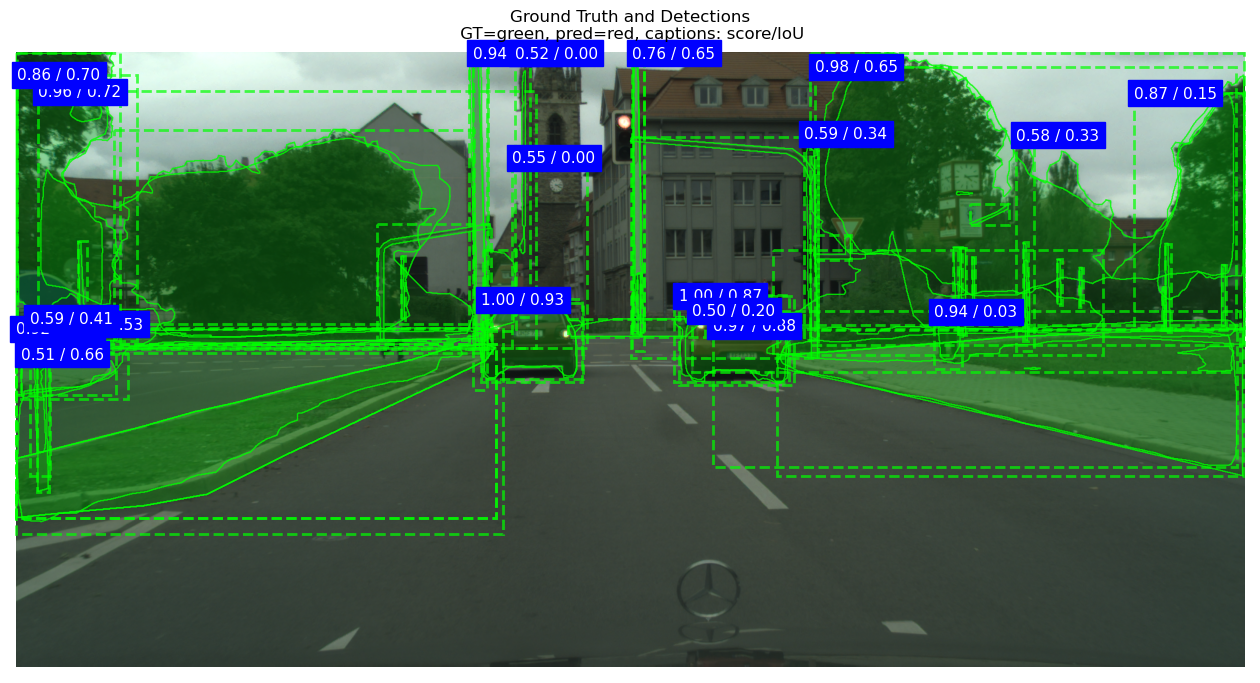

In [367]:
visualize.display_differences(image,
                    gt_bbox, gt_class_ids, gt_mask,
                    bboxes, class_ids, class_scores, masks,
                    dataset.class_names, title="", ax=None,
                    show_mask=True, show_box=True,
                    iou_threshold=0.5, score_threshold=0.5)

# Functions

In [60]:
# # id =222
# gt_mask, gt_class_ids, gt_obs = dataset.load_mask(id)
# gt_bbox = utils.extract_bboxes(gt_mask)

# image = dataset.load_image(id)
# # detect
# results = model.detect([image],verbose=0)
# bboxes, masks, class_ids, class_scores, obs_ids, obs_scores = helper.parse_detections(results)


# # detect 
# # TP/FP/FN

# # iou overlaps of masks
# # matches 
# gt_id_match, pred_id_match, id_overlaps = utils.compute_matches(gt_bbox, gt_class_ids, gt_mask,
#                 bboxes, class_ids, class_scores, masks,
#                 iou_threshold=0.25, score_threshold=0.0)

# gt_obs_match, pred_obs_match, obs_overlaps = utils.compute_matches(gt_bbox, gt_obs , gt_mask,
#                 bboxes, obs_ids, obs_scores, masks,
#                 iou_threshold=0.25, score_threshold=0.0)


```
for detection_scores>thres:
    compute_overlap_matches:
        if iou<thres: FP
        else: TN
```

In [7]:

def compute_overlaps_masks(masks1, masks2, DICE=False):
    """Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """
    
    # If either set of masks is empty return empty result
    if masks1.shape[-1] == 0 or masks2.shape[-1] == 0:
        return np.zeros((masks1.shape[-1], masks2.shape[-1]))
    # flatten masks and compute their areas
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union
    if DICE:
        return overlaps, intersections, area1,area2
    return overlaps

In [375]:
def get_overlaps(groundtruths, detections, intersection=False, SCORE_THRES=0.0, IOU_THRES=0.5):
    # will be used for object detection bounding boxes 
    # and calculating the dice scores 
    gt_boxes, gt_masks, gt_class_id = groundtruths
    pred_boxes, pred_masks, pred_class_ids, pred_scores = detections

    # modified original utils computaiton
    # returns iou between boxes and masks
    gt_boxes = utils.trim_zeros(gt_boxes)
    gt_masks = gt_masks[..., :gt_boxes.shape[0]]
    pred_boxes = utils.trim_zeros(pred_boxes)
    pred_scores = pred_scores[:pred_boxes.shape[0]]
    # Sort predictions by score from high to low
    indices = np.argsort(pred_scores)[::-1]
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]
    pred_masks = pred_masks[..., indices]

    # compute IoU overlaps between bounding boxes
    if len(gt_boxes) > len(pred_boxes): #passing larger set for performance
        box_overlaps = utils.compute_overlaps(gt_boxes, pred_boxes)
    else:
        box_overlaps = utils.compute_overlaps(pred_boxes, gt_boxes)
    
    if intersection:
        overlaps, mask_intersections,area1,area2 = compute_overlaps_masks(pred_masks, gt_masks, intersection)
    
    else:
        overlaps = compute_overlaps_masks(pred_masks, gt_masks, intersection)
    
    # Loop through predictions and find matching ground truth boxes
    match_count = 0
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
    gt_match = -1 * np.ones([gt_boxes.shape[0]])
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        # 1. Sort matches by score
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        # 2. Remove low scores
        low_score_idx = np.where(overlaps[i, sorted_ixs] < SCORE_THRES)[0]
        if low_score_idx.size > 0:
            sorted_ixs = sorted_ixs[:low_score_idx[0]]
        # 3. Find the match
        for j in sorted_ixs:
            # If ground truth box is already matched, go to next one
            if gt_match[j] > -1:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < IOU_THRES:
                break
            # Do we have a match?
            if pred_class_ids[i] == gt_class_ids[j]:
                match_count += 1
                gt_match[j] = i
                pred_match[i] = j
                break
    
    if intersection:
        return gt_match, pred_match, overlaps, mask_intersections,area1,area2, box_overlaps
    
    return gt_match, pred_match, masks_overlaps, box_overlaps
    # return box_overlaps, mask_overlaps


def get_confusion_matrix(gt_class_ids, class_ids, class_scores,overlaps, dim = 11, SCORE_THRES=0.25, IOU_THRES=0.5):
    conf_mat = np.zeros((dim,dim)) # rows: predicted, cols: gt
    TP, FP, FN = 0,0,0
    # pairs of largest iou overlaps 
    
    matches = np.array([np.arange(0,len(overlaps)),np.argmax(overlaps, axis=1)]).T
    for x,y in matches:
        gt_id, pred_id = gt_class_ids[y],class_ids[x]
        if class_scores[x] > SCORE_THRES:
            if ( gt_id!= pred_id) or (overlaps[x][y] < IOU_THRES):
                if overlaps[x][y] < IOU_THRES: 
                    conf_mat[0][gt_id]+=1
                else: 
                    conf_mat[pred_id][gt_id]+=1
                FP+=1
            else:
                # print(gt_id,pred_id,class_scores[x],overlaps[x][y])
                TP+=1
                conf_mat[gt_id][pred_id] +=1
    else:
        conf_mat[pred_id][0]+=1
        FN+=1
    return conf_mat


def calculate_dice_score(matches, intersections, area1, area2):
    # get the largest iou for each overlap 
    # calculate just the matches tho
    intersects = intersections[matches]
    # if len(area1) == len(matches[0]):
    #     DICE = 2*intersects/(area1[matches[0]]+area2[matches[1]])
    # else:
    #     DICE = 2*intersects/(area1[matches[1]]+area2[matches[0]])
    DICE = 2*intersects/(area1[matches[0]]+area2[matches[1]])

    return DICE

In [381]:
# for multiclass
groundtruths = gt_bbox, gt_mask, gt_class_ids
detections = bboxes, masks, class_ids, class_scores

# find the best match of each bounding box & masks
gt_match, pred_match, mask_overlaps, mask_intersections,area1,area2, box_overlaps = get_overlaps(groundtruths, detections,True)
idx = np.where(pred_match>-1)[0]
matches = np.arange(0,len(idx)),pred_match[idx].astype(np.int32)    # pred_idx, gt_idx
# selecting just the obstruction labels
gt_obs_match, pred_obs_match = gt_obs[matches[1]], obs_ids[matches[0]]

conf= get_confusion_matrix(gt_class_ids, class_ids, class_scores,box_overlaps.T, dim = 11, SCORE_THRES=0.5, IOU_THRES=0.5)
# print(conf)

binary_conf = get_confusion_matrix(gt_obs+1, obs_ids+1, obs_scores,box_overlaps.T, dim = 3, SCORE_THRES=0.0, IOU_THRES=0.5)
# print(binary_conf)

dice = calculate_dice_score(matches, mask_intersections, area1, area2)  # how to do dice score for each class
# print(dice)

In [338]:
# for multilabel - filter the obstructions
groundtruths = gt_bbox, gt_mask, gt_obs
detections = bboxes, masks, obs_ids, obs_scores

# find the best match of each bounding box & masks
gt_match, pred_match, mask_overlaps, mask_intersections,area1,area2 = get_overlaps(groundtruths, detections,True, IOU_THRES=0.1)
idx = np.where(pred_match>-1)[0]
matches = np.arange(0,len(idx)),pred_match[idx].astype(np.int32)

conf= get_confusion_matrix(gt_obs, obs_ids, obs_scores, mask_overlaps, dim = 2, SCORE_THRES=0.5, IOU_THRES=0.5)
dice = calculate_dice_score(matches, mask_intersections, area1, area2)  # how to do dice score for each class

print(conf)
print(dice)

[[1. 0.]
 [1. 0.]]
[0.31619078 0.27020958]


# Evluation

In [617]:
# calculate for iou thres 0.1, 0.25, 0.5, 0.75
ious = [.1,.25,.5,.7]
ious

[0.1, 0.25, 0.5, 0.7]

In [618]:
multi_class_conf_mat = np.zeros((dataset.num_classes, dataset.num_classes,4))
binary_conf_mat = np.zeros((3, 3,4))

In [619]:
multi_class_conf_mat = np.zeros((dataset.num_classes, dataset.num_classes,4))
binary_conf_mat = np.zeros((3, 3,4))
dice_scores = [[],[],[],[]]
all_matches = [[],[],[],[]]
binary_matches = [[],[],[],[]]


for ids in dataset.image_ids:
    if ids%25==0: print(f'Processed {ids} images')
    image = dataset.load_image(ids)
    # detection
    results = model.detect([image],verbose=0)
    bboxes, masks, class_ids, class_scores, obs_ids, obs_scores = helper.parse_detections(results)

    # for multiclass
    groundtruths = gt_bbox, gt_mask, gt_class_ids
    detections = bboxes, masks, class_ids, class_scores

    for i in range(len(ious)):
        iou = ious[i]
        # find the best match of each bounding box & masks
        gt_match, pred_match, mask_overlaps, mask_intersections,area1,area2, box_overlaps = get_overlaps(groundtruths, detections,True, IOU_THRES = iou)
        box_overlaps = box_overlaps.T
        idx = np.where(pred_match>-1)[0]
        matches = np.arange(0,len(idx)),pred_match[idx].astype(np.int32)    # pred_idx, gt_idx
        gt_ids_match, pred_ids_match = gt_class_ids[matches[1]], class_ids[matches[0]]
        all_matches[i].append((gt_ids_match, pred_ids_match ))
        
        # selecting just the obstruction labels
        gt_obs_match, pred_obs_match = gt_obs[matches[1]], obs_ids[matches[0]]
        binary_matches[i].append((gt_obs_match, pred_obs_match))
        # # calculate eval metric confusion use bbox 
        # multi_class_conf_mat[...,i] += get_confusion_matrix(gt_class_ids, class_ids, class_scores,box_overlaps, dim = 11, SCORE_THRES=0.0, IOU_THRES=iou)
        # binary_conf_mat[...,i]= get_confusion_matrix(gt_obs+1, obs_ids+1, obs_scores,box_overlaps, dim = 3, SCORE_THRES=0.0, IOU_THRES=iou)

        # dice use semgentaion
        dice = calculate_dice_score(matches, mask_intersections, area1, area2)  # how to do dice score for each class
        dice_scores[i].append(dice)

Processed 0 images
Processed 25 images
Processed 50 images
Processed 75 images
Processed 100 images
Processed 125 images
Processed 150 images
Processed 175 images
Processed 200 images
Processed 225 images
Processed 250 images
Processed 275 images
Processed 300 images
Processed 325 images


# compute precision recall

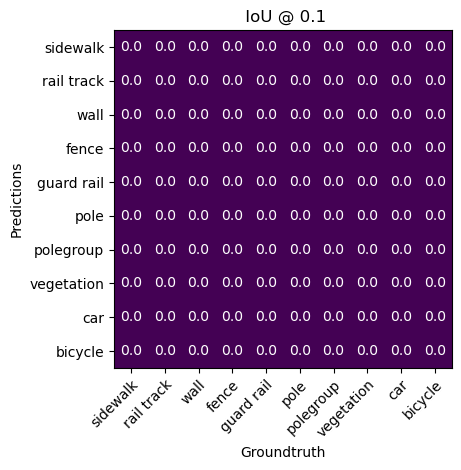

In [620]:
vegetables = dataset.class_names[1:]
farmers = dataset.class_names[1:]

# harvest =  multi_class_conf_mat[...,0][1:,1:]/np.sum(multi_class_conf_mat[...,0][1:,1:])
harvest =  multi_class_conf_mat[...,0][1:,1:]


fig, ax = plt.subplots()
im = ax.imshow(harvest)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(farmers)), labels=farmers)
ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        text = ax.text(j, i, round(harvest[i, j],2),
                       ha="center", va="center", color="w")


ax.set_xlabel('Groundtruth')
ax.set_ylabel('Predictions')
ax.set_title(" IoU @ 0.1")
fig.tight_layout()
plt.show()

In [548]:
# vegetables = ['Not-obstructions','obstructions']
# farmers = vegetables

# harvest =  binary_conf_mat[...,1][1:,1:]/np.sum(binary_conf_mat[...,1][1:,1:])

# harvest = binary_conf_mat[...,0][1:,1:]
# fig, ax = plt.subplots()
# im = ax.imshow(harvest)

# # Show all ticks and label them with the respective list entries
# ax.set_xticks(np.arange(len(farmers)), labels=farmers)
# ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

# # Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# # Loop over data dimensions and create text annotations.
# for i in range(len(vegetables)):
#     for j in range(len(farmers)):
#         text = ax.text(j, i, round(harvest[i, j],2),
#                        ha="center", va="center", color="w")

# ax.set_title("Binary Labels")
# fig.tight_layout()
# plt.show()

In [621]:
avg= [[],[],[],[]]
for i in range(4):
    dice = dice_scores[i]
    for d in dice:
        d = np.nan_to_num(d,0)
        avg[i].append(np.mean(d))
    avg[i] = np.nan_to_num(avg[i],0)
    print(f'AVG DICE @ IOU={ious[i]} = {np.mean(avg[i])}')
    

AVG DICE @ IOU=0.1 = 0.08048049360513687
AVG DICE @ IOU=0.25 = 0.07890189439058304
AVG DICE @ IOU=0.5 = 0.026875339448451996
AVG DICE @ IOU=0.7 = 0.008778896182775497


/Users/csea/miniconda/envs/tf/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/csea/miniconda/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [584]:
y_true = [[],[],[],[]]
y_pred = [[],[],[],[]]
for i in range(4):
    matches = binary_matches[i]
    for n in matches:
        y = n[0]
        y_hat = n[1]
        for j in range(len(y)):
            y_true[i].append(y[j])
            y_pred[i].append(y_hat[j])

# binary
target_names = ['Non-obstruction','Obstructions']
for i in range(4):
    print(f'IoU @ {ious[i]}')
    print('-----------------------------------------------------------')

    print(classification_report(y_true[i], y_pred[i], target_names=target_names))
    print('-----------------------------------------------------------')


IoU @ 0.1
-----------------------------------------------------------
                 precision    recall  f1-score   support

Non-obstruction       0.72      0.21      0.32       989
   Obstructions       0.34      0.84      0.49       491

       accuracy                           0.42      1480
      macro avg       0.53      0.52      0.41      1480
   weighted avg       0.60      0.42      0.38      1480

-----------------------------------------------------------
IoU @ 0.25
-----------------------------------------------------------
                 precision    recall  f1-score   support

Non-obstruction       0.71      0.20      0.31       536
   Obstructions       0.35      0.83      0.49       271

       accuracy                           0.41       807
      macro avg       0.53      0.52      0.40       807
   weighted avg       0.58      0.41      0.37       807

-----------------------------------------------------------
IoU @ 0.5
---------------------------------------

/Users/csea/miniconda/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/csea/miniconda/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/csea/miniconda/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [612]:
y_true = [[],[],[],[]]
y_pred = [[],[],[],[]]
for i in range(4):
    matches = all_matches[i]
    for n in matches:
        y = n[0]
        y_hat = n[1]
        for j in range(len(y)):
            y_true[i].append(y[j])
            y_pred[i].append(y_hat[j])

# binary
for i in range(4):

    target_names = [dataset.class_names[i] for i in list((np.unique(y_pred[i])).astype(np.int64))]

    print(f'IoU @ {ious[i]}')
    print('-----------------------------------------------------------')

    print(classification_report(y_true[i], y_pred[i], target_names=target_names))
    print('-----------------------------------------------------------')


IoU @ 0.1
-----------------------------------------------------------
              precision    recall  f1-score   support

    sidewalk       0.57      0.22      0.32       643
       fence       0.00      0.00      0.00         0
        pole       0.14      0.25      0.18        65
  vegetation       0.44      0.23      0.30       480
         car       0.30      0.84      0.44       292
     bicycle       0.00      0.00      0.00         0

    accuracy                           0.35      1480
   macro avg       0.24      0.26      0.21      1480
weighted avg       0.46      0.35      0.33      1480

-----------------------------------------------------------
IoU @ 0.25
-----------------------------------------------------------
              precision    recall  f1-score   support

    sidewalk       0.60      0.19      0.29       386
        pole       0.16      0.32      0.21        19
  vegetation       0.43      0.16      0.24       265
         car       0.24      0.93      

/Users/csea/miniconda/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/csea/miniconda/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/csea/miniconda/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/csea/miniconda/envs/tf/lib/

['sidewalk', 'fence', 'pole', 'vegetation', 'car', 'bicycle']

# Extra

In [363]:
# for multiclass
groundtruths = gt_bbox, gt_mask, gt_class_ids
detections = bboxes, masks, class_ids, class_scores

# find the best match of each bounding box & masks
gt_match, pred_match, mask_overlaps, mask_intersections,area1,area2 = get_overlaps(groundtruths, detections,True)
idx = np.where(pred_match>-1)[0]
matches = np.arange(0,len(idx)),pred_match[idx].astype(np.int32)    # pred_idx, gt_idx
# selecting just the obstruction labels
gt_obs_match, pred_obs_match = gt_obs[matches[1]], obs_ids[matches[0]]

conf= get_confusion_matrix(gt_class_ids, class_ids, class_scores,mask_overlaps, dim = 11, SCORE_THRES=0.0, IOU_THRES=0.25)
# print(conf)

binary_conf= get_confusion_matrix(gt_obs, obs_ids, obs_scores,mask_overlaps, dim = 3, SCORE_THRES=0.0, IOU_THRES=0.25)
# print(binary_conf)

dice = calculate_dice_score(matches, mask_intersections, area1, area2)  # how to do dice score for each class
# print(dice)

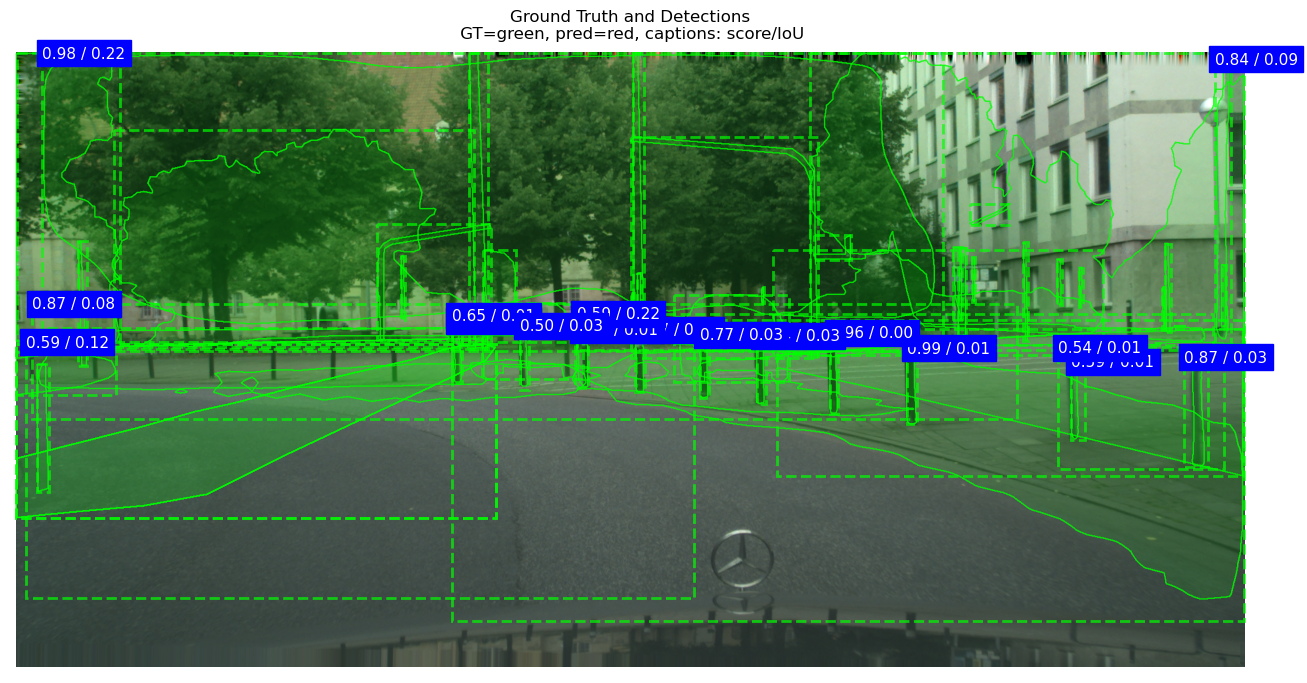

In [393]:
visualize.display_differences(image,
                    gt_bbox, gt_class_ids, gt_mask,
                    bboxes, class_ids, class_scores, masks,
                    dataset.class_names, title="", ax=None,
                    show_mask=True, show_box=True,
                    iou_threshold=0.5, score_threshold=0.5)